In [1]:
import pandas as pd
import numpy as np
import backtest
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from log_data import StockData

import os

from dotenv import load_dotenv
from log_data import StockData
from datetime import datetime

import sys
import backtest

# Baixando dados das ações
df = pd.read_parquet('cotacoes_acoes.parquet')
df_ibov = pd.read_parquet('ibov.parquet')
df_ibov.rename(columns={'indice': 'ticker', 'valor': 'preco_fechamento_ajustado'}, inplace=True)
df_ibov['ticker'] = df_ibov['ticker'].replace('IBOV', 'BOVA11')
df_smal =  pd.read_parquet('smll.parquet')
df_smal.rename(columns={'indice': 'ticker', 'valor': 'preco_fechamento_ajustado'}, inplace=True)
df_smal['ticker'] = df_smal['ticker'].replace('SMLL', 'SMAL11')
df_ibov['data'] = pd.to_datetime(df_ibov['data']); df_smal['data'] = pd.to_datetime(df_smal['data'])
df = pd.concat([df, df_ibov, df_smal], ignore_index=True)
df.fillna(0, inplace=True)
df.info()

## upload data
load_dotenv()
ambiente_local = os.getenv('AMBIENTE_MAC')
datapath_cdi = 'cdi_historico.xlsx'
cdi_data = backtest.cdidata_extract(ambiente_local+datapath_cdi)
# salvando arquvio parquet criado
# df.to_parquet('base_acoes.parquet', engine='pyarrow')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650895 entries, 0 to 1650894
Data columns (total 12 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   data                       1650895 non-null  datetime64[ns]
 1   preco_abertura             1650895 non-null  float64       
 2   preco_fechamento           1650895 non-null  float64       
 3   preco_maximo               1650895 non-null  float64       
 4   preco_medio                1650895 non-null  float64       
 5   preco_minimo               1650895 non-null  float64       
 6   quantidade_negociada       1650895 non-null  float64       
 7   quantidade_negocios        1650895 non-null  float64       
 8   ticker                     1650895 non-null  object        
 9   volume_negociado           1650895 non-null  float64       
 10  fator_ajuste               1650895 non-null  float64       
 11  preco_fechamento_ajustado  1650895 no

In [2]:
# Dados ativos mais líquidos mes a mes
def valores_unicos_df(dataframe):
    valores_unicos = []
    for coluna in dataframe.columns[1:]:
        valores_unicos_coluna = list(dataframe[coluna].unique())
        valores_unicos.extend(valores_unicos_coluna)
    valores_unicos = list(set(valores_unicos))

    return valores_unicos

# Função para extrair o ano (primeiros 4 caracteres)
def extrair_ano(data):
    return data[:4]

# Função para extrair o valor após o hífen
def extrair_apos_hifen(data):
    partes = data.split('-')
    if len(partes) > 1:
        return partes[1]
    else:
        return None  

arquivo = 'portfolio_quant_RANK_12.csv'


portfolio_liquidez = pd.read_csv(arquivo, delimiter=',', header=None)
# tickers_strategy = valores_unicos_df(portfolio_liquidez)
portfolio_liquidez.tail(5)
portfolio_liquidez.shape
# portfolio_liquidez = portfolio_liquidez.iloc[:, 0:5]
portfolio_liquidez['Ano'] = portfolio_liquidez[0].apply(extrair_ano)
portfolio_liquidez['Mes'] = portfolio_liquidez[0].apply(extrair_apos_hifen)
tickers_strategy = valores_unicos_df(portfolio_liquidez); tickers_strategy.append('BOVA11')
portfolio_liquidez.head(5)


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,Ano,Mes
0,2010-12,VALE5,PETR4,OGXP3,ITUB4,BVMF3,BBDC4,USIM5,GGBR4,BBAS3,...,MRVE3,CCRO3,TELB4,CMIG4,SANB11,JBSS3,LAME4,TAMM4,2010,12
1,2011-01,VALE5,PETR4,OGXP3,ITUB4,BVMF3,BBDC4,USIM5,GGBR4,BBAS3,...,MMXM3,CCRO3,SANB11,CMIG4,TELB4,JBSS3,LAME4,NATU3,2011,01
2,2011-02,VALE5,PETR4,OGXP3,ITUB4,BVMF3,BBDC4,USIM5,BBAS3,GGBR4,...,MMXM3,CCRO3,SANB11,CMIG4,JBSS3,NATU3,LAME4,BRAP4,2011,02
3,2011-03,VALE5,PETR4,OGXP3,ITUB4,BVMF3,BBDC4,BBAS3,USIM5,GGBR4,...,MMXM3,CCRO3,SANB11,CMIG4,NATU3,LAME4,JBSS3,RSID3,2011,03
4,2011-04,VALE5,PETR4,OGXP3,ITUB4,BVMF3,BBDC4,BBAS3,GGBR4,USIM5,...,CCRO3,SANB11,CMIG4,NATU3,LAME4,VIVO4,RSID3,BRAP4,2011,04


In [3]:
# Objeto dados das ações
stock_data = StockData(df, tickers_selecionados=tickers_strategy)

stock_data.dates = stock_data.dates[252:-2]
stock_data.price_matrix = stock_data.price_matrix[252:-2, :]

print(len(tickers_strategy))
print(type(tickers_strategy))
print(stock_data.price_matrix.shape)
valores_nao_comuns = [valor for valor in tickers_strategy if valor not in stock_data.tickers]
weekdays = [StockData.date_to_weekday(date) for date in stock_data.dates]
# print(weekdays[:5])
# print(valores_nao_comuns)
print(stock_data.dates[:4])

121
<class 'list'>
(3172, 95)
[Timestamp('2011-01-10 00:00:00'), Timestamp('2011-01-11 00:00:00'), Timestamp('2011-01-12 00:00:00'), Timestamp('2011-01-13 00:00:00')]


In [4]:
# Verificação Ativos Início e Fim
assets_trading = 'Ativos backtest: '
for ticker in stock_data.tickers:
    assets_trading += ticker+' , '

print(assets_trading, '\n')
print('Inicio Backtest: ', stock_data.dates[0])
print('Fim do Backtest: ', stock_data.dates[-1])
# print('Return Benchmark _ Strategy Long Bova11: ', round( stock_data.price_matrix[-1,stock_data.tickers.index('BOVA')]/ stock_data.price_matrix[0,stock_data.tickers.index('BOVA')] - 1, 2))

Ativos backtest: ITSA4 , VALE3 , AMBV4 , EMBR3 , EQTL3 , BRFS3 , PDGR3 , HYPE3 , PETR4 , ESTC3 , CCRO3 , LAME4 , VALE5 , ELET3 , TAMM4 , BRKM5 , PCAR5 , GGBR4 , GFSA3 , BVMF3 , USIM5 , BTOW3 , BRAP4 , WEGE3 , GOLL4 , GOAU4 , MMXM3 , LREN3 , MRVE3 , FIBR3 , HGTX3 , OGXP3 , TELB4 , NATU3 , RDCD3 , BRML3 , SANB11 , ITUB4 , CYRE3 , CSNA3 , RSID3 , SULA11 , CTIP3 , JBSS3 , BBAS3 , SUZB5 , BBDC4 , SBSP3 , CMIG4 , VIVO4 , RENT3 , CIEL3 , CSAN3 , UGPA3 , BRPR3 , HRTP3 , AEDU3 , PCAR4 , MGLU3 , QUAL3 , TIMP3 , VIVT4 , RADL3 , KROT3 , OIBR4 , OIBR3 , VVAR3 , BBTG11 , SMLE3 , BBSE3 , ABEV3 , KLBN11 , RUMO3 , PRIO3 , BPAC11 , RAIL3 , AZUL4 , IRBR3 , SUZB3 , BRDT3 , B3SA3 , GNDI3 , HAPV3 , BIDI11 , COGN3 , NTCO3 , LWSA3 , CASH3 , RRRP3 , RDOR3 , ASAI3 , AMER3 , VIIA3 , VBBR3 , BOVA11 ,  

Inicio Backtest:  2011-01-10 00:00:00
Fim do Backtest:  2023-10-27 00:00:00


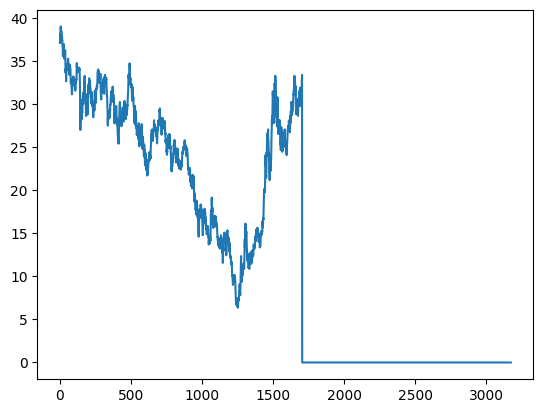

In [5]:
plt.plot(stock_data.price_matrix[:,stock_data.tickers.index('VALE5')])

In [6]:
# backtest
contagem_dias = np.zeros(stock_data.price_matrix.shape[1])
capital_alocacao = np.zeros((stock_data.price_matrix.shape[0], stock_data.price_matrix.shape[1] + 1))
resultado_alocacao = np.zeros((stock_data.price_matrix.shape[0], stock_data.price_matrix.shape[1] + 1))
capital_alocacao[0, -1] = 1

# Alocação portfolio
retorno_treshold = -0.10
periodo_position = 5 # input("Nr de dias posicionado: ")
cash = 1.0


for i, day in enumerate(stock_data.dates):

    # identificar mes e ano
    ano = str(day.year); mes = str(day.month)
    cash = capital_alocacao[0, -1]

    if len(mes) == 1:
        mes = '0' + mes
    
    # pegar a linha do joao com o portfolio desejado
    stocks2trade = portfolio_liquidez[(portfolio_liquidez['Ano'] == str(ano)) & (portfolio_liquidez['Mes'] == str(mes))]    
    if not stocks2trade.empty:
        stocks2trade = stocks2trade.iloc[0,1:-2].tolist()
    else:
        stocks2trade = []
        print('Falta mes e ano na portfolio de liquidez')
        sys.exit()        

    for i2, tickers in enumerate(stocks2trade):
        if tickers != 'XPBR31':

            capital_alocacao[i, stock_data.tickers.index(tickers)] = capital_alocacao[i-1, stock_data.tickers.index(tickers)]

            if stock_data.price_matrix[i, stock_data.tickers.index(tickers)] != 0:

                if capital_alocacao[i, stock_data.tickers.index(tickers)] != 0:

                    contagem_dias[stock_data.tickers.index(tickers)] += 1

                    if contagem_dias[stock_data.tickers.index(tickers)] >= int(periodo_position): 

                        # capital_alocacao[i, stock_data.tickers.index(tickers)], cash = backtest.simple_update_capital(cash, 'sell')
                        capital_alocacao[i, stock_data.tickers.index(tickers)] = 0
                        contagem_dias[stock_data.tickers.index(tickers)] = 0 

                if weekdays[i] == 'sexta':
                    preco_ontem = stock_data.price_matrix[i-1, stock_data.tickers.index(tickers)]
                    # print(weekdays[i-1])
                    preco_sextapassada = stock_data.price_matrix[i-4, stock_data.tickers.index(tickers)]
                    # print(weekdays[i-4])
                    retorno_semanal = backtest.calculate_return(preco_sextapassada, preco_ontem)
                    # print(f'Retorno semanal: {retorno_semanal}, de acordo com {weekdays[i-4]} e {weekdays[i-1]}.')

                    if retorno_semanal > retorno_treshold and cash >= 0.10:
                        capital_alocacao[i, stock_data.tickers.index(tickers)], cash = backtest.simple_update_capital(cash, 'buy')                        
                        contagem_dias[stock_data.tickers.index(tickers)] = 0
                    
                    else:
                        continue

    if cash < -0.001 or cash > 1:
        print('SYSTEM ERROR - cash out of reality')
        print(cash)
        sys.exit()
    else:
        # cash = 1 - np.sum(capital_alocacao[i, :-1])
        capital_alocacao[i, -1] = cash

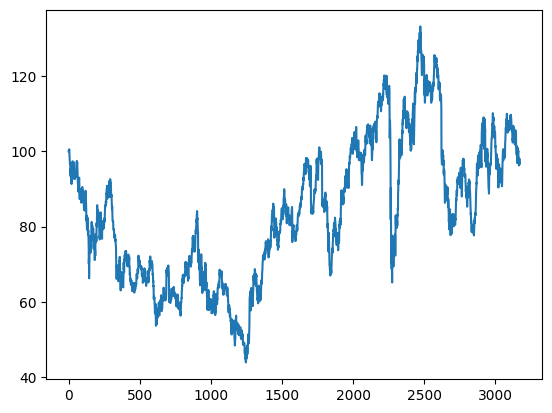

In [7]:
equity = backtest.curva_capital(100, stock_data.dates, stock_data.price_matrix, capital_alocacao, stock_data.tickers, resultado_alocacao)

plt.plot(equity)  

In [ ]:
# Building Equity Curve // Revisar
equity =[100]

for i, day in enumerate(stock_data.dates[1:], start=1):

    for i2, ticker in enumerate(stock_data.tickers):

        if stock_data.price_matrix[i-1, i2] != 0: 

            position_ticker = capital_alocacao[i, i2]

            day_return = backtest.calculate_return(stock_data.price_matrix[i-1, i2], stock_data.price_matrix[i, i2])

            resultado_alocacao[i, i2] = position_ticker*day_return

    equity.append((np.sum(resultado_alocacao[i, :])) * equity[i-1] + equity[i-1])

plt.plot(equity)    

In [ ]:
# Building Equity Curve with cash
equity_cash =[100]
resultado_alocacao = np.zeros((stock_data.price_matrix.shape[0], stock_data.price_matrix.shape[1] + 1))

for i, day in enumerate(stock_data.dates[1:], start=1):

    ano = day.year; mes = day.month

    for i2 in range(capital_alocacao.shape[1]):

        if i2 == (capital_alocacao.shape[1]-1): # if it is cash
            linhas_correspondentes = cdi_data[(cdi_data[:, 2] == mes) & (cdi_data[:, 3] == ano)]
            position_ticker = capital_alocacao[i, i2]
            day_return = (linhas_correspondentes[0][1]+1)**(1/252)-1
            resultado_alocacao[i, i2] = position_ticker*day_return

        elif stock_data.price_matrix[i-1, i2] != 0: 
            position_ticker = capital_alocacao[i, i2]
            day_return = backtest.calculate_return(stock_data.price_matrix[i-1, i2], stock_data.price_matrix[i, i2])
            resultado_alocacao[i, i2] = position_ticker*day_return

    equity_cash.append((np.sum(resultado_alocacao[i, :])) * equity_cash[i-1] + equity_cash[i-1])

    plt.plot(equity_cash)    

In [ ]:
# Building Equity Curve - Benchmark
equity_benchmark =[100]
for i, day in enumerate(stock_data.dates[1:], start=1):

    day_return = backtest.calculate_return(stock_data.price_matrix[i-1, stock_data.tickers.index('BOVA11')], stock_data.price_matrix[i, stock_data.tickers.index('BOVA11')])
    
    equity_benchmark.append(day_return * equity_benchmark[i-1] + equity_benchmark[i-1])

plt.plot(equity_benchmark)

In [ ]:
equity_benchmark_cash =[100]

for i, day in enumerate(stock_data.dates[1:], start=1):

    linhas_correspondentes = cdi_data[(cdi_data[:, 2] == mes) & (cdi_data[:, 3] == ano)]
    position_ticker = 0.5
    day_return_cash = (linhas_correspondentes[0][1]+1)**(1/252)-1
    day_return = backtest.calculate_return(stock_data.price_matrix[i-1, stock_data.tickers.index('BOVA11')], stock_data.price_matrix[i, stock_data.tickers.index('BOVA11')])    
    # print(f'Cash: {day_return_cash}')
    # print(f'Equity: {day_return}')          

    equity_benchmark_cash.append( (day_return * equity_benchmark_cash[i-1]*0.5) + (day_return_cash * equity_benchmark_cash[i-1]*0.5) + equity_benchmark_cash[i-1])

plt.plot(equity_benchmark_cash)

In [ ]:
cash_pl =[100]
print(stock_data.dates[1])

for i, day in enumerate(stock_data.dates[1:], start=1):

    linhas_correspondentes = cdi_data[(cdi_data[:, 2] == mes) & (cdi_data[:, 3] == ano)]
    day_return_cash = (linhas_correspondentes[0][1]+1)**(1/252)-1         

    cash_pl.append( (day_return_cash * cash_pl[i-1]) + cash_pl[i-1])

plt.plot(cash_pl)

In [ ]:
equity = np.array(equity)
equity_cash = np.array(equity_cash)
equity_benchmark_cash = np.array(equity_benchmark_cash)
cash_pl = np.array(cash_pl)
result_column_stack = np.column_stack((equity, equity_cash, equity_benchmark_cash, cash_pl))
column_titles = ['Strategy Equity', 'Strategy with Cash', 'Benchmark', 'CDI']

colors = ['blue', 'green', 'red', 'black']  
plt.figure(figsize=(10,6))

# datestring = np.array(stock_data.dates)
dates = stock_data.dates # [stock_data.dates for date in stock_data.dates]
for i, color in enumerate(colors):
    plt.plot(dates, result_column_stack[:,i], color=color, label=column_titles[i])

plt.title('Gráfico das colunas')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()

# Configura o formato da data no eixo x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=150))  # Ajuste o intervalo conforme necessário

# Rotação das datas no eixo x para melhor visualização
plt.gcf().autofmt_xdate()

plt.show()

In [ ]:
# baixa dados do insignia e mach5 
# pesquisa 3
import mysql.connector
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

db = mysql.connector.connect(
    user= 'cartor',
    password= 'Cartor1212!',
    host= "cartor.mysql.dbaas.com.br",
    port= 3306,
    database= 'cartor',
    )

msql = pd.read_sql_query("SELECT * from cota_fundos", db)
print(msql.columns)
msql = msql.reset_index(drop=True)  # remove o índice atual e substitui por um índice padrão


In [ ]:
# Backtest Insignia
insignia_pl =[100]
dates = np.array(msql['Date']); dates = dates[5:-2]
ativo = ['insignia']
cotacao_insignia = np.array(msql['quota_insignia']);  cotacao_insignia = cotacao_insignia[5:-2]
array_posicao = np.ones(cotacao_insignia.shape)

print(dates[0])
print(dates[-1])
print(cotacao_insignia.shape)
print(array_posicao.shape)

for i, day in enumerate(dates[1:], start=1):

    position_acao = array_posicao[i]
    retorno_dia = backtest.calculate_return(cotacao_insignia[i-1], cotacao_insignia[i])
    insignia_pl.append( retorno_dia * insignia_pl[i-1] + insignia_pl[i-1])\
    
plt.plot(insignia_pl)

In [ ]:
# Backtest MACH5
mach5_pl =[100]
dates = np.array(msql['Date']); dates = dates[5:-2]
ativo = ['mach5']
cotacao_mach5 = np.array(msql['quota_mach5']); cotacao_mach5 = cotacao_mach5[5:-2]  
array_posicao = np.ones(cotacao_mach5.shape)

print(f'Inicio: {dates[0]}')
print(f'Fim: {dates[-1]}')
print(cotacao_mach5.shape)
print(array_posicao.shape)

for i, day in enumerate(dates[1:], start=1):

    position_acao = array_posicao[i]
    retorno_dia = backtest.calculate_return(cotacao_mach5[i-1], cotacao_mach5[i])
    mach5_pl.append( retorno_dia * mach5_pl[i-1] + mach5_pl[i-1])\
    
plt.plot(mach5_pl)

In [ ]:
start_date = pd.Timestamp('2022-08-08')
end_date = pd.Timestamp('2023-10-27')

# Supondo que stock_data.dates seja uma lista ou uma Series pandas de objetos Timestamp:
filtered_timestamps = [timestamp for timestamp in stock_data.dates if start_date <= timestamp <= end_date]

# Contando os valores
count = len(filtered_timestamps)

In [ ]:
# Baixar novos arquivos Jonhy 

import pandas as pd

# Dados ativos mais líquidos mes a mes
def valores_unicos_df(dataframe):
    valores_unicos = []
    for coluna in dataframe.columns[1:]:
        valores_unicos_coluna = list(dataframe[coluna].unique())
        valores_unicos.extend(valores_unicos_coluna)
    valores_unicos = list(set(valores_unicos))

    return valores_unicos

# Função para extrair o ano (primeiros 4 caracteres)
def extrair_ano(data):
    return data[:4]

# Função para extrair o valor após o hífen
def extrair_apos_hifen(data):
    partes = data.split('-')
    if len(partes) > 1:
        return partes[1]
    else:
        return None  

portfolio_liquidez = pd.read_csv('portfolio_quant_RANK_12.csv', delimiter=',', header=None)
# tickers_strategy = valores_unicos_df(portfolio_liquidez)
portfolio_liquidez.tail(5)
portfolio_liquidez.shape
# portfolio_liquidez = portfolio_liquidez.iloc[:, 0:5]
portfolio_liquidez['Ano'] = portfolio_liquidez[0].apply(extrair_ano)
portfolio_liquidez['Mes'] = portfolio_liquidez[0].apply(extrair_apos_hifen)
tickers_strategy = valores_unicos_df(portfolio_liquidez)
portfolio_liquidez.head(5)